# Handwritten Digit Classfication using Deep Feed Foward Neural Network

The tutorial presented will again tackle the MNIST digit classification problem. You can find more information from the previous [MNIST introduction](introduction_to_mnist.ipynb) tutorial. This time, we will build a deep feed forward neural network to help us solve the problem, which is actually a Multilayer Perceptron with two hidden layers illustrated in the diagram below. In a feed forward network information always **moves one direction instead of ever going backwards**, i.e. it has no loop or cycle inside. It's the simplest type of neural networks so it's easy and great to start with to be familiar with how to use BigDL to unleash its power.

![model structure](tutorial_images/deep_feed_forward_NN/feedforwardNN_structure.png)

Note:
---
*You can find that in the project [README](https://github.com/intel-analytics/BigDL-Tutorials), the notebooks of topic 8~14 share a similar content structure and deal with the same MNIST digit classification problem but with differenet models. We think it's convenient for readers to learn the tutorials if we summarize the common steps of these tutorials here so users can take it as a guidance when tackling other problems of their interest*:

1. Load MNIST dataset
2. Hyperparameter setup
3. Model creation  (*where tutorials differ*)
4. Optimzer setup and training
5. Training loss visualization
6. Prediction on test data

Without further-ado, let's delve into the code!


In [1]:
import matplotlib
matplotlib.use('Agg')
%pylab inline
import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from utils import get_mnist
import matplotlib.pyplot as plt
from pyspark import SparkContext
from matplotlib.pyplot import imshow

sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))
init_engine()

Populating the interactive namespace from numpy and matplotlib


## 1. Load MNIST dataset

First, we should get and store MNIST into RDD of Sample.


Note: *edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, mnist.read_data_sets method will download the dataset directly to the directory*.

In [2]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


## 2. Hyperparameter setup

In [3]:
learning_rate = 0.2
training_epochs = 15
batch_size = 2048
display_step = 1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

## 3. Model creation

Let's define our multilayer_perceptron(MLP) model with 2 hidden layers here.

In [4]:

# Create model

def multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Reshape([28*28]))
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # Hidden layer with ReLu activation
    model.add(Linear(n_hidden_1, n_hidden_2).set_name('mlp_fc2'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_2, n_classes).set_name('mlp_fc3'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes)

creating: createSequential
creating: createReshape
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


## 4. Optimizer setup and training

Let's create an optimizer for training. As presented in the code, we are trying to optimize a [ClassNLLCriterion](https://bigdl-project.github.io/master/#APIGuide/Losses/#classnllcriterion) and use Stochastic Gradient Descent to update the weights. Also in order to enable visualization support, we need to [generate summary info in BigDL](https://bigdl-project.github.io/master/#ProgrammingGuide/visualization/).

In [5]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='multilayer_perceptron-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to ",app_name

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  multilayer_perceptron-20171221-151115


In [6]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 33.3 s


## 5. Loss visualization

After training, we can draw the preformance curves from the previous `train_summary` and `val_summary` variables.

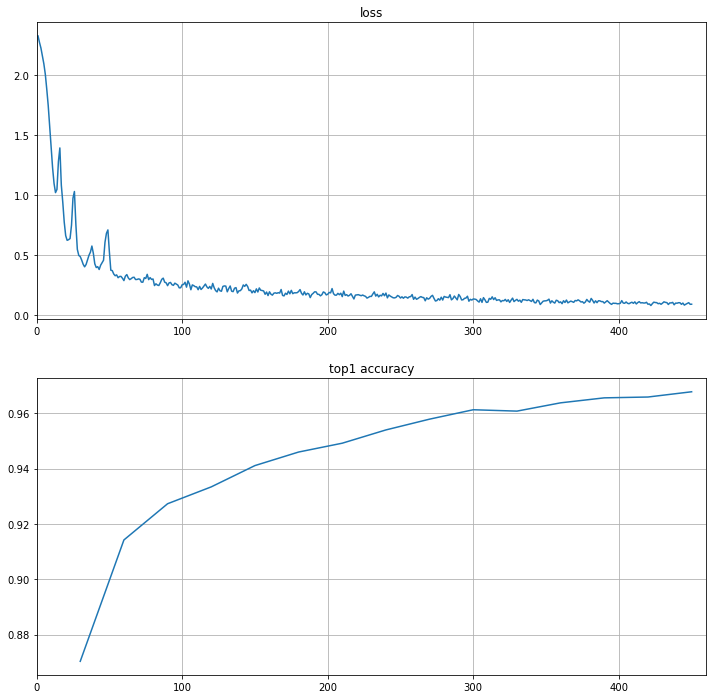

In [7]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)

## 6. Prediction on test data

Now, let's see the prediction results on test data by our trained model.

In [8]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

Ground Truth labels:
7, 2, 1, 0, 4, 1, 4, 9
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9
CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 364 ms


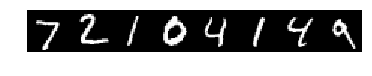

In [9]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8))
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))